# Capstone Project 2: Twitter Public Opinion Network Analysis for Bungie

This project's goal is to collect and analyze the available Twitter data for Bungie and their main game, Destiny 2.

The data I am collecting are tweets about Bungie and Destiny 2 and the timelines (tweets made by) the Bungie and Destiny 2 official accounts.

This notebook is the data wrangling for the project, mostly calls to the Twitter API (https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets.html ).

In [1]:
import pandas as pd
from pandas.io.json import json_normalize

import requests
from requests_oauthlib import OAuth1
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from datetime import datetime

### Testing Requests

The user rate limit is 180 requests per 15 min for the default api

Here are all of the other rate limits: https://developer.twitter.com/en/docs/basics/rate-limits

This is the base url for the Twitter API

In [2]:
twitter_url = 'https://api.twitter.com/1.1/search/tweets.json'

I will need an API key, secret, token, and token secret, but I will never save them in this file.

There are a couple different authentication methods

I will see which ones I need

https://developer.twitter.com/en/docs/basics/authentication/overview/oauth

The one below is OAuth1

In [3]:
"""
OAuth1('API_KEY',
'API_SECRET_KEY',
'ACCESS_TOKEN',
'ACCESS_TOKEN_SECRET')
"""   
auth = OAuth1()

These are some of the parameters I can use in my requests:

The 'max_id' parameter is very important. max_id roughly correlates with time, so a tweet that has a higher ID than another tweet was made after that tweet. Assigning max_id repeatedly within a loop allows me to prevent repeatedly pulling the same tweets.

In [86]:
params = {
    # General search term
    'q': 'destiny 2',
    
    # Others
    'lang': 'en',
    'result_type': 'recent',
    'count': '100',
    'include_entities': 'false'
}

In [87]:
params

{'count': '100',
 'include_entities': 'false',
 'lang': 'en',
 'max_id': 1100761992720134144L,
 'q': 'destiny 2',
 'result_type': 'recent'}

This request can be used to verify that my credentials worked.

I want to see Response code 200

In [72]:
credential_url = 'https://api.twitter.com/1.1/account/verify_credentials.json'

In [73]:
requests.get(credential_url, auth=auth)

<Response [200]>

Okay, let's pull some tweets

In [88]:
tweets = requests.get(twitter_url, params=params, auth=auth)
tweets

<Response [200]>

Here's the raw JSON

In [89]:
tweets.json()

{u'search_metadata': {u'completed_in': 0.004,
  u'count': 100,
  u'max_id': 1100761992720134144L,
  u'max_id_str': u'1100761992720134144',
  u'query': u'destiny+2',
  u'refresh_url': u'?since_id=1100761992720134144&q=destiny%202&lang=en&result_type=recent',
  u'since_id': 0,
  u'since_id_str': u'0'},
 u'statuses': []}

The json only has 2 top-level keys

In [90]:
tweets.json().keys()

[u'search_metadata', u'statuses']

I don't really need the search metadata. Isolate the tweets themselves

In [96]:
tweets.json()['statuses']

True

In [12]:
tweets.headers

{'content-length': '42276', 'x-rate-limit-reset': '1552439965', 'x-rate-limit-remaining': '179', 'x-xss-protection': '1; mode=block; report=https://twitter.com/i/xss_report', 'x-content-type-options': 'nosniff', 'x-connection-hash': '0506205efaffbeec6b95fd84b15e8532', 'x-twitter-response-tags': 'BouncerCompliant', 'cache-control': 'no-cache, no-store, must-revalidate, pre-check=0, post-check=0', 'status': '200 OK', 'content-disposition': 'attachment; filename=json.json', 'set-cookie': 'personalization_id="v1_0zeROWLiRk16aknnlJ4lxg=="; Max-Age=63072000; Expires=Fri, 12 Mar 2021 01:04:25 GMT; Path=/; Domain=.twitter.com, guest_id=v1%3A155243906564739627; Max-Age=63072000; Expires=Fri, 12 Mar 2021 01:04:25 GMT; Path=/; Domain=.twitter.com', 'expires': 'Tue, 31 Mar 1981 05:00:00 GMT', 'x-access-level': 'read-write', 'last-modified': 'Wed, 13 Mar 2019 01:04:25 GMT', 'pragma': 'no-cache', 'date': 'Wed, 13 Mar 2019 01:04:25 GMT', 'x-rate-limit-limit': '180', 'x-response-time': '324', 'x-trans

Each entry has these fields. Some of the fields (like entities) have several sub-fields.

Some of the engagement metrics are 'favorite_count' and 'retweet_count'

'Created_at' / 'id' will be important for my time-ordering

should I restrict my language to English?

I don't think I can see how many comments there are. Oh I think those are replies. I can self-join or make the network based on 'in_reply_to_status_id_str', I think.

In [13]:
tweets.json()['statuses'][0].keys()

[u'contributors',
 u'truncated',
 u'text',
 u'is_quote_status',
 u'in_reply_to_status_id',
 u'id',
 u'favorite_count',
 u'retweeted',
 u'coordinates',
 u'source',
 u'in_reply_to_screen_name',
 u'in_reply_to_user_id',
 u'retweet_count',
 u'id_str',
 u'favorited',
 u'retweeted_status',
 u'user',
 u'geo',
 u'in_reply_to_user_id_str',
 u'lang',
 u'created_at',
 u'in_reply_to_status_id_str',
 u'place',
 u'metadata']

In [14]:
tweets.json()['statuses'][0]['metadata']

{u'iso_language_code': u'en', u'result_type': u'recent'}

Make a dataframe of the tweets

In [15]:
df = json_normalize(tweets.json()['statuses'])
df

,contributors,coordinates,created_at,favorite_count,favorited,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,...,user.profile_text_color,user.profile_use_background_image,user.protected,user.screen_name,user.statuses_count,user.time_zone,user.translator_type,user.url,user.utc_offset,user.verified
0,None,None,Wed Mar 13 01:03:25 +0000 2019,0,False,None,1105635439904473088,1105635439904473088,None,NaN,...,333333,True,False,Germain58055796,62,None,none,None,None,False
1,None,None,Wed Mar 13 01:02:49 +0000 2019,0,False,None,1105635291375656960,1105635291375656960,None,NaN,...,333333,True,False,Cygamerok,8065,None,none,https://t.co/DTbLRNRmOm,None,False
2,None,None,Wed Mar 13 01:02:24 +0000 2019,2,False,None,1105635187071700992,1105635187071700992,None,NaN,...,333333,False,False,loadingreadyrun,16532,None,none,http://t.co/p69e6Lcx7H,None,False
3,None,None,Wed Mar 13 01:02:01 +0000 2019,0,False,None,1105635090263142400,1105635090263142400,None,NaN,...,3394C8,False,False,techradar,57882,None,none,https://t.co/bjLoW5yMKX,None,True
4,None,None,Wed Mar 13 01:01:00 +0000 2019,1,False,None,1105634831004766210,1105634831004766210,None,NaN,...,000000,False,False,shutterman1801,215,None,none,https://t.co/bu71D3JnJz,None,False
5,None,None,Wed Mar 13 01:00:46 +0000 2019,0,False,None,1105634774146797568,1105634774146797568,None,NaN,...,000000,False,False,OdinRa_,5273,None,none,https://t.co/0xdUheHGjY,None,False
6,None,None,Wed Mar 13 01:00:44 +0000 2019,0,False,None,1105634764483190784,1105634764483190784,None,NaN,...,000000,False,False,barf_ebooks,4468,None,none,None,None,False
7,None,None,Wed Mar 13 01:00:31 +0000 2019,0,False,None,1105634711811043328,1105634711811043328,None,NaN,...,666666,True,False,OPM_UK,38109,None,none,https://t.co/fcMu5TmiLX,None,True
8,None,None,Wed Mar 13 01:00:04 +0000 2019,0,False,None,1105634596102832129,1105634596102832129,None,NaN,...,000000,False,False,StreamSupport3,48003,None,none,https://t.co/DkXgW9FQxS,None,False
9,None,None,Wed Mar 13 01:00:01 +0000 2019,0,False,None,1105634585495437313,1105634585495437313,None,NaN,...,333333,True,False,StormyElitist,2063,None,none,None,None,False


Here is the text of the 100 tweets

In [16]:
df.text

0     RT @TPHDallas: Are you feeling uncertain for w...
1     RT @TheOGPatriotX: Lets get this ball rolling....
2     On tonight's Talking Simulator, Cameron and sp...
3     Destiny 2 news, updates and DLC https://t.co/k...
4     Check out my broadcast from my PlayStation 4! ...
5     Check out my broadcast from my PlayStation 4! ...
6     I WATCHED TOY STORY 1 FOR THE FIRST 3 HOURS OF...
7     An incoming Destiny 2 update will finally buff...
8     Kappa @janpiert1 is playing Destiny 2 at https...
9     RT @TheOGPatriotX: Lets get this ball rolling....
10    RT @FateStayNightUS: The crossroads of destiny...
11    RT @TPHDallas: Are you feeling uncertain for w...
12    Thorn quest and comp #PS4live (Destiny 2)  liv...
13    Check out coolironman97   plays  destiny 2 htt...
14    RT @BPELive: What's does a badass metal man do...
15    👍 on @YouTube: Destiny 2 Lore - Allegiance Qu...
16           @DeeJ_BNG Re-Skin large scale = Destiny 2.
17    RT @TPHDallas: Are you feeling uncertain fo

Plotting favorites vs retweets

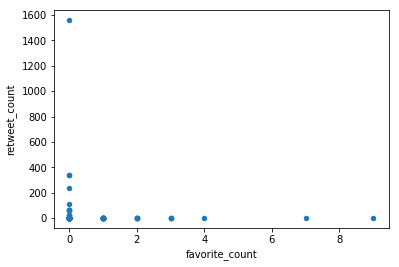

In [17]:
df.plot.scatter(x='favorite_count', y='retweet_count')
plt.show()

Here is how I can access the highest and lowest IDs in a dataframe of tweets.

In [18]:
df.sort_values('id', ascending=True).iloc[0, 6]#.head(1)['id'].values[0]

1105622065724444673

In [19]:
df.sort_values('id', ascending=False).iloc[0, 6]#.head(1)['id'].values[0]

1105635439904473088

In [54]:
df.id.min()

1105622065724444673

In [55]:
df.id.max()

1105635439904473088

### Bias?

I need to have a way to get a representative sample of tweets. I am concerned that if I order tweets by time, this may have bias.

But then the question becomes: How many tweets do I need? I probably shouldn't take them all, since that violates the independence condition of statistical analyses.

### Consideration about IDs

https://developer.twitter.com/en/docs/tweets/timelines/guides/working-with-timelines

The search API will return an ordering based on ID. You should set max_id or since_id to make sure calls aren't redundant.

This seems like it depends on a temporal ordering, like for timelines. 

### Followers

If I want to make a network, I can get accounts' followers. This does depend on having a complete-ish set of data, which may not be possible with the Standard Twitter Search API.

There are a couple requests explained in here: https://developer.twitter.com/en/docs/accounts-and-users/follow-search-get-users/api-reference

Get Followers: Will get all the user IDs for people that follow the account in question

Get Friends: Will get all the user IDs for people that the account in question in following

### Time Sensitivity

Try to get 25k - 50k tweets. I will try to get 20k tweets from each block (Destiny / Bungie).

I can only pull tweets from the last week ish. Getting followers / friendships can happen at any time.

The pokemon / nintendo project idea will be scrapped, since it took too long to figure the duplicate tweet problem out, and the free, standard twitter api only allows access to the last week of data.

I need to figure out how to make sure I get all independent tweets in my data collection.

### Tweet duplication problem

I'm trying to redo and test the loop to eradicate duplicates. 

Testing: does the value for max_id need to be an int or a string? INT

Does the starting value matter? DON"T HAVE A STARTING VALUE

Are there actually just not enough tweets? At len 50, I only had duplicates of some tweets, nothing higher.

at len 100, I only had triples of tweets.

PROBLEM: I was doing a weird dataframe ordering and .iloc to get the lowest tweet, when I should have just taken the ID column as a series and done .min().

#### Code Refactoring

Let's make a function so that this all runs cleaner

In [114]:
def find_tweets_on_topic(topic, block_size, block_num):
    
    # This block should search for any recent tweets involving the input topic
    params = {
        # General search term
        'q': topic,
    
        # Others
        'lang': 'en',
        'result_type': 'recent',
        'count': block_size,
        'include_entities': 'false'
    }
    
    # Set up variables for input later
    twitter_url = 'https://api.twitter.com/1.1/search/tweets.json'
    current_min = float("inf")
    tweets_list = []

    while (len(tweets_list) < block_num):
        # Get the tweets
        tweets = requests.get(twitter_url, params=params, auth=auth)
        
        # If I can't get anymore tweets, be done
        if tweets.json()['statuses'] == []:
            print("Empty Response Found. Exiting Loop.")
            break
            
        # Add tweets to the list
        sub_df = json_normalize(tweets.json()['statuses'])
        tweets_list.append(sub_df)
        
        # Set up max_id on the first time through
        if 'max_id' not in params.keys():
            current_min = sub_df.id.min()
            params['max_id'] = current_min
            # The following line was the old way I found current_min, and is wrong
            #params['max_id'] = sub_df.sort_values('id', ascending=True).iloc[0, 7]
        
        # Change max_id if it is lower than what we currently have
        else:
            new_min = sub_df.id.min()
            if new_min < current_min :
                current_min = new_min
                params['max_id'] = current_min
    
        # I can do 180 requests per 15 minutes
        # This is the same as a request every 5 seconds
        # I will go a little slower than that
        time.sleep(6)
        
    # Make the final dataframe
    tweet_df = pd.concat(tweets_list, sort=False)
    
    # Print statements for performance
    print("Number of tweets: %d" % len(tweet_df.id))
    print("Number of unique tweets: %d" % len(tweet_df.id.drop_duplicates()))
    print("Max number of duplicates: %d" % tweet_df.id.value_counts().values.max())
    
    # Return the dataframe
    return tweet_df

In [31]:
destiny_2_tweet_df = find_tweets_on_topic("destiny 2", 5, 10)

Number of tweets: 46
Number of unique tweets: 46
Max number of duplicates: 1


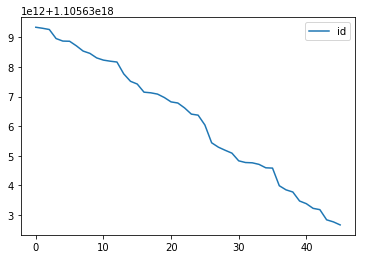

In [34]:
destiny_2_tweet_df.reset_index().plot(y='id')

Result using ID as an int

In [35]:
destiny_2_tweet_df = find_tweets_on_topic("destiny 2", 100, 100)

Number of tweets: 9994
Number of unique tweets: 1122
Max number of duplicates: 10


Result using ID as a string

In [40]:
destiny_2_tweet_df = find_tweets_on_topic("destiny 2", 100, 100)

Number of tweets: 9999
Number of unique tweets: 1109
Max number of duplicates: 11


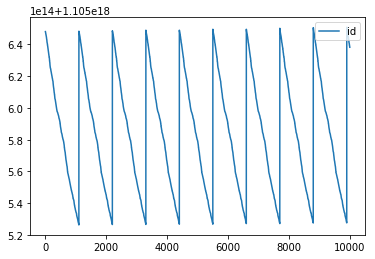

In [41]:
destiny_2_tweet_df.reset_index().plot(y='id')

The oldest tweet in this database is from today, a little earlier than 6 pm. I ran the code around 7:30 pm. I should be able to access tweets older than this.

In [44]:
destiny_2_tweet_df[destiny_2_tweet_df['id'] == destiny_2_tweet_df.id.min()]

,contributors,coordinates,created_at,favorite_count,favorited,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,...,retweeted_status.place.country_code,retweeted_status.place.full_name,retweeted_status.place.id,retweeted_status.place.name,retweeted_status.place.place_type,retweeted_status.place.url,coordinates.coordinates,coordinates.type,geo.coordinates,geo.type
99,None,NaN,Tue Mar 12 17:49:37 +0000 2019,0,False,NaN,1105526272854237190,1105526272854237190,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
destiny_2_tweet_df = find_tweets_on_topic("destiny 2", 100, 25)

Number of tweets: 2500
Number of unique tweets: 1093
Max number of duplicates: 4


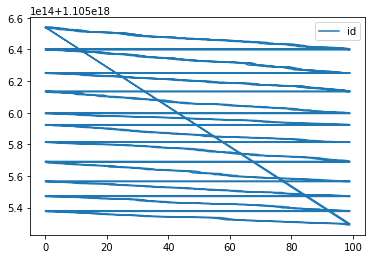

In [53]:
destiny_2_tweet_df.plot(y='id')

Change function to only change the max id if it is lower than the previous one

Since I appear to be gathering repeating tweets

In [61]:
destiny_2_tweet_df = find_tweets_on_topic("destiny 2", 100, 25)

Number of tweets: 2500
Number of unique tweets: 1194
Max number of duplicates: 14


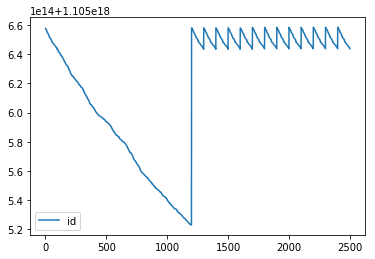

In [64]:
destiny_2_tweet_df.reset_index().plot(y='id')

Changing the max_id parameter to be an integer again.

In [66]:
destiny_2_tweet_df = find_tweets_on_topic("destiny 2", 100, 25)

Number of tweets: 2433
Number of unique tweets: 2409
Max number of duplicates: 2


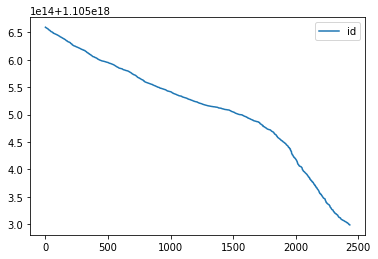

In [67]:
destiny_2_tweet_df.reset_index().plot(y='id')

Hoooooly cow this actually worked.

In [68]:
destiny_2_tweet_df = find_tweets_on_topic("destiny 2", 100, 100)

Number of tweets: 9807
Number of unique tweets: 9708
Max number of duplicates: 2


What happens when I run out of tweets to collect? What do I check?

Let's pass a max_id that I know is over a week old.

In [111]:
params = {
    # General search term
    'q': 'destiny 2',
    
    # Others
    'lang': 'en',
    'result_type': 'recent',
    'count': '100',
    'include_entities': 'false',
    'max_id': 1100761992720134144
}

In [112]:
tweets = requests.get(twitter_url, params=params, auth=auth)
tweets
#tweets.json()['statuses']

<Response [200]>

In [113]:
tweets.headers

{'content-length': '201', 'x-rate-limit-reset': '1552499104', 'x-rate-limit-remaining': '179', 'x-xss-protection': '1; mode=block; report=https://twitter.com/i/xss_report', 'x-content-type-options': 'nosniff', 'x-connection-hash': '0db5c9d9d4ff547d4ce9ae0e057bf6ab', 'x-twitter-response-tags': 'BouncerCompliant', 'cache-control': 'no-cache, no-store, must-revalidate, pre-check=0, post-check=0', 'status': '200 OK', 'content-disposition': 'attachment; filename=json.json', 'set-cookie': 'personalization_id="v1_h8549UZMcp7p2hA9yYEnAw=="; Max-Age=63072000; Expires=Fri, 12 Mar 2021 17:30:04 GMT; Path=/; Domain=.twitter.com, guest_id=v1%3A155249820492196462; Max-Age=63072000; Expires=Fri, 12 Mar 2021 17:30:04 GMT; Path=/; Domain=.twitter.com', 'expires': 'Tue, 31 Mar 1981 05:00:00 GMT', 'x-access-level': 'read-write', 'last-modified': 'Wed, 13 Mar 2019 17:30:04 GMT', 'pragma': 'no-cache', 'date': 'Wed, 13 Mar 2019 17:30:04 GMT', 'x-rate-limit-limit': '180', 'x-response-time': '20', 'x-transact

Okay. So the top-level keys are still present, but the 'statuses' block where the tweets should be is an empty list. I can check for that.

#### Collect official data

In [115]:
destiny_2_tweet_df = find_tweets_on_topic("destiny 2", 100, 250)

Empty Response
Number of tweets: 21661
Number of unique tweets: 21442
Max number of duplicates: 2


In [116]:
bungie_tweet_df = find_tweets_on_topic("bungie", 100, 250)

Number of tweets: 24984
Number of unique tweets: 24735
Max number of duplicates: 2


Cool! I got a lot of tweets. Let's cull the duplicates, reset the index, and make the created_at column a datetime object.

In [126]:
destiny_2_tweet_df = destiny_2_tweet_df.reset_index(drop=True).drop_duplicates(subset=['id'])
len(destiny_2_tweet_df)

21442

In [137]:
destiny_2_tweet_df.loc[:, 'created_at'] = \
  [datetime.strptime(destiny_2_tweet_df.loc[i, 'created_at'][0:-11],
                     "%a %b %d %H:%M:%S").replace(year=2019) for i in destiny_2_tweet_df.index]

In [140]:
bungie_tweet_df = bungie_tweet_df.reset_index(drop=True).drop_duplicates(subset=['id'])
len(bungie_tweet_df)

24735

In [142]:
bungie_tweet_df.loc[:, 'created_at'] = \
  [datetime.strptime(bungie_tweet_df.loc[i, 'created_at'][0:-11],
                     "%a %b %d %H:%M:%S").replace(year=2019) for i in bungie_tweet_df.index]

Save this data!

In [144]:
destiny_2_tweet_df.to_csv('..\\data\\destiny_2_tweets.csv', encoding='utf-8')
bungie_tweet_df.to_csv('..\\data\\bungie_tweets.csv', encoding='utf-8')

What is the earliest tweet found in these dataframes?

In [159]:
print(destiny_2_tweet_df.id.min())
print(bungie_tweet_df.id.min())

1102240804469379075
1102953113022091264


### Timelines

I want to get the Twitter timelines for the twitter accounts of Destiny 2 (@DestinyTheGame) and Bungie (@Bungie).

Let's modify the function above to use the different request. The response json is also different. I don't need to get the statuses in the json, as this response is effectively a list of statuses.

In [160]:
def find_timeline_by_user(screen_name, block_size, block_num):
    
    # This block should search for any recent tweets involving the input topic
    params = {
        # General search term
        'screen_name': screen_name,
    
        # This request can go further back than a week,
        # So I should stop it from doing so
        # This is the earliest tweet in my previous 2 dataframes
        'since_id': 1102240804469379075,
        'count': block_size,
        'exclude_replies': 'false'
    }
    
    # Set up variables for input later
    twitter_url = 'https://api.twitter.com/1.1/statuses/user_timeline.json'
    current_min = float("inf")
    tweets_list = []

    while (len(tweets_list) < block_num):
        # Get the tweets
        tweets = requests.get(twitter_url, params=params, auth=auth)
        
        # If I can't get anymore tweets, be done
        if tweets.json() == []:
            print("Empty Response Found. Exiting Loop.")
            break
            
        # Add tweets to the list
        sub_df = json_normalize(tweets.json())
        tweets_list.append(sub_df)
        
        # Set up max_id on the first time through
        if 'max_id' not in params.keys():
            current_min = sub_df.id.min()
            params['max_id'] = current_min
            # The following line was the old way I found current_min, and is wrong
            #params['max_id'] = sub_df.sort_values('id', ascending=True).iloc[0, 7]
        
        # Change max_id if it is lower than what we currently have
        else:
            new_min = sub_df.id.min()
            if new_min < current_min :
                current_min = new_min
                params['max_id'] = current_min
    
        # I can do 900 requests per 15 minutes
        # This is the same as a request every 1 second
        # I will go a little slower than that
        time.sleep(1.2)
        
    # Make the final dataframe
    tweet_df = pd.concat(tweets_list, sort=False)
    
    # Print statements for performance
    print("Number of tweets: %d" % len(tweet_df.id))
    print("Number of unique tweets: %d" % len(tweet_df.id.drop_duplicates()))
    print("Max number of duplicates: %d" % tweet_df.id.value_counts().values.max())
    
    # Return the dataframe
    return tweet_df

Get timelines for @Bungie and @DestinyTheGame, reset index, insure tweet uniqueness, and set datetimes.

In [161]:
bungie_timeline_df = find_timeline_by_user('Bungie', 200, 100)

Number of tweets: 206
Number of unique tweets: 107
Max number of duplicates: 100


In [166]:
bungie_timeline_df = bungie_timeline_df.reset_index(drop=True).drop_duplicates(subset=['id'])
len(bungie_timeline_df)

107

In [167]:
bungie_timeline_df.loc[:, 'created_at'] = \
  [datetime.strptime(bungie_timeline_df.loc[i, 'created_at'][0:-11],
                     "%a %b %d %H:%M:%S").replace(year=2019) for i in bungie_timeline_df.index]

In [170]:
bungie_timeline_df.to_csv('..\\data\\bungie_timeline.csv', encoding='utf-8')

In [171]:
destiny_2_timeline_df = find_timeline_by_user('DestinyTheGame', 200, 100)

Number of tweets: 145
Number of unique tweets: 46
Max number of duplicates: 100


In [173]:
destiny_2_timeline_df = destiny_2_timeline_df.reset_index(drop=True).drop_duplicates(subset=['id'])
len(destiny_2_timeline_df)

46

In [174]:
destiny_2_timeline_df.loc[:, 'created_at'] = \
  [datetime.strptime(destiny_2_timeline_df.loc[i, 'created_at'][0:-11],
                     "%a %b %d %H:%M:%S").replace(year=2019) for i in destiny_2_timeline_df.index]

In [175]:
destiny_2_timeline_df.to_csv('..\\data\\destiny_2_timeline.csv', encoding='utf-8')